In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import io
import zipfile

file_path = '/content/drive/MyDrive/Dataset/kualitas_buah.zip'

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content/dataset/kualitas_buah')
zip_ref.close()

In [ ]:
train_dir = '/content/dataset/kualitas_buah/train'
val_dir = '/content/dataset/kualitas_buah/val'
test_dir = '/content/dataset/kualitas_buah/test'

In [ ]:
BATCH_SIZE = 32
EPOCHS = 100
IMG_WIDTH, IMG_HEIGHT = 224, 224
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
LEARNING_RATE = 1e-3

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

normal_datagen = ImageDataGenerator(
    rescale=1./255
)

train_data = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = normal_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = normal_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5988 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)

for layer in base_model.layers:
  layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/100
188/188 [==============================] - 433s 2s/step - loss: 0.4665 - accuracy: 0.8415 - val_loss: 0.2116 - val_accuracy: 0.9300
Epoch 2/100
188/188 [==============================] - 422s 2s/step - loss: 0.1472 - accuracy: 0.9544 - val_loss: 0.1912 - val_accuracy: 0.9420
Epoch 3/100
188/188 [==============================] - 390s 2s/step - loss: 0.0947 - accuracy: 0.9694 - val_loss: 0.1007 - val_accuracy: 0.9710
Epoch 4/100
188/188 [==============================] - 420s 2s/step - loss: 0.0848 - accuracy: 0.9731 - val_loss: 0.0407 - val_accuracy: 0.9900
Epoch 5/100
188/188 [==============================] - 426s 2s/step - loss: 0.0663 - accuracy: 0.9786 - val_loss: 0.0723 - val_accuracy: 0.9720
Epoch 6/100
188/188 [==============================] - 422s 2s/step - loss: 0.0530 - accuracy: 0.9816 - val_loss: 0.0337 - val_accuracy: 0.9910
Epoch 7/100
188/188 [==============================] - 368s 2s/step - loss: 0.0455 - accuracy: 0.9860 - val_loss: 0.0376 - val_accuracy:

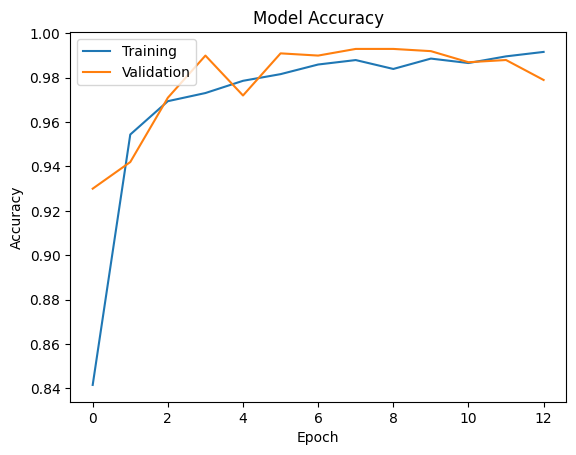

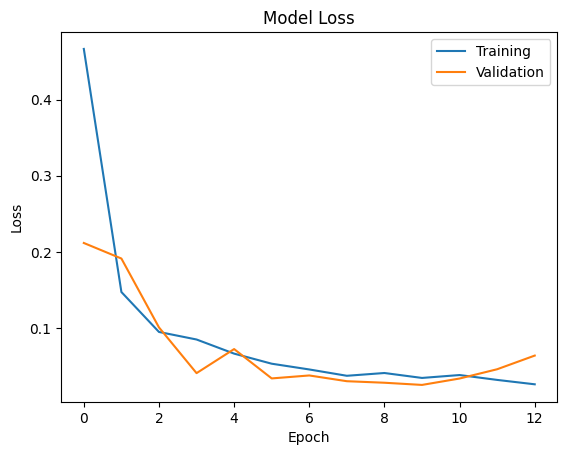

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
scores = model.evaluate(test_data)

print('Akurasi: %.2f%%' % (scores[1] * 100))

16/16 [==============================] - 28s 2s/step - loss: 0.0465 - accuracy: 0.9840
Akurasi: 98.40%


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

16/16 [==============================] - 23s 1s/step


array([[ 6,  8,  4,  4,  3,  5,  6,  5,  3,  6],
       [ 3,  6,  5,  5,  7,  5,  4,  6,  6,  3],
       [ 7,  7,  2,  4,  3,  5,  7,  3,  8,  4],
       [ 4,  9,  6,  5,  4,  5,  5,  6,  5,  1],
       [ 5,  3,  9,  5,  7,  3,  4,  2,  5,  7],
       [ 4,  4,  4,  7,  4,  7,  7,  4,  4,  5],
       [ 4,  3,  7, 10,  9,  6,  2,  2,  4,  3],
       [ 8,  4,  3,  3,  5,  3,  6, 10,  2,  6],
       [ 6,  3,  4,  3,  4,  5,  4,  4,  8,  9],
       [ 5,  3,  0,  7,  5,  6,  5,  8,  5,  6]])

In [ ]:
print(cm)

[[ 6  8  4  4  3  5  6  5  3  6]
 [ 3  6  5  5  7  5  4  6  6  3]
 [ 7  7  2  4  3  5  7  3  8  4]
 [ 4  9  6  5  4  5  5  6  5  1]
 [ 5  3  9  5  7  3  4  2  5  7]
 [ 4  4  4  7  4  7  7  4  4  5]
 [ 4  3  7 10  9  6  2  2  4  3]
 [ 8  4  3  3  5  3  6 10  2  6]
 [ 6  3  4  3  4  5  4  4  8  9]
 [ 5  3  0  7  5  6  5  8  5  6]]


In [ ]:
print(cr)

                precision    recall  f1-score   support

    Apel Busuk       0.12      0.12      0.12        50
    Apel Segar       0.12      0.12      0.12        50
   Jeruk Busuk       0.05      0.04      0.04        50
   Jeruk Segar       0.09      0.10      0.10        50
  Mangga Busuk       0.14      0.14      0.14        50
  Mangga Segar       0.14      0.14      0.14        50
  Pisang Busuk       0.04      0.04      0.04        50
  Pisang Segar       0.20      0.20      0.20        50
Stroberi Busuk       0.16      0.16      0.16        50
Stroberi Segar       0.12      0.12      0.12        50

      accuracy                           0.12       500
     macro avg       0.12      0.12      0.12       500
  weighted avg       0.12      0.12      0.12       500

